In [11]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

import daft
from gensim.models.doc2vec import Word2Vec
import json
from IPython.display import SVG, display
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras.models import Model, Sequential, model_from_json
from keras.datasets import mnist, cifar10, imdb
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GRU, Input, RepeatVector, TimeDistributed, Merge, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter

In [2]:
import sys
import os
project_path = os.getcwd() + '/../../'
sys.path.append(project_path + "utils")
sys.path.append(project_path + "data")
sys.path.append(project_path + "multi_models/cnn/")
sys.path.append(project_path + "multi_models/timeseries_model/")
sys.path.append(project_path + "multi_models/knn/")

In [3]:
# utils
import analysis
import function
import other
import local_bayes
import visualize

In [4]:
# data
from base import BaseDataManager
import get_normal_representation 
from preprocessing import Preprocessing
from data import Data

In [5]:
import numpy
from keras.layers import LSTM, GRU, SimpleRNN
sys.path.append(project_path + "multi_models/knn/")

In [34]:
%load_ext autoreload
%autoreload 2
from timeseries_model import TimeseriesModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## make data

In [35]:
data_name_ls = ['science', 'ajax', 'java', 'news', 'css', 'javascript', 'opensource', 'webdesign', 'design', 'linux', 'photography']
raw_data_dir = project_path + 'original_data/bookmark/'
save_data_dir = project_path + 'data/datasets/bookmark_new/'
train_test_ratio = 0.8
stride = 5
balance = True
output_dim_ls = [6]

base_data_manager = BaseDataManager(raw_data_dir, save_data_dir)
D = Data(raw_data_dir, save_data_dir)
P = Preprocessing(raw_data_dir, save_data_dir)

In [162]:
for output_dim in output_dim_ls:
    
    for data_name in data_name_ls:
        print data_name
        data = base_data_manager.load_data('%s.twd' % data_name)
        ts_ls, ts_sum_ls = get_normal_representation.get_ts_normal_representation(data)
        ts_dict = base_data_manager.div_train_test(ts_ls, train_test_ratio)
        started_ts_dict = base_data_manager.get_started_ts(ts_dict)
        input_ts_dict, label_dict, target_ts_dict, input_sum_dict = \
                                    base_data_manager.make_supervised_data(started_ts_dict, stride, output_dim)
        if balance:
            input_ts_dict, label_dict, target_ts_dict = P.balancing_sampling(input_ts_dict, label_dict, target_ts_dict, output_dim)
            data_type = 'balance'
        else:
            data_type = 'normal'
        D.make_train_data(input_ts_dict, label_dict, target_ts_dict, output_dim, data_type, data_name)

science
ajax
java
news
css
javascript
opensource
webdesign
design
linux
photography


## data load

In [7]:
data_type = 'balance'
output_dim = 6
save_data_dir = '../../data/datasets/bookmark_new/%s/' % data_type
train_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/train.npz' % output_dim)
test_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/test.npz' % output_dim)
target_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/target.npz' % output_dim)

In [8]:
rows = 1
cols = 30
nb_classes = 2
x_train = train_ajax['x'].reshape(train_ajax['x'].shape[0], 1, rows, cols)
x_test = test_ajax['x'].reshape(test_ajax['x'].shape[0], 1, rows, cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

y_train = train_ajax['y']
y_test = test_ajax['y']

(778, 1, 1, 30)
train samples: 778
test samples: 322


In [9]:
for i in xrange(output_dim):
    all_, sum_ = 0, 0
    for ele in test_ajax['y'][:, i]:
        if abs(ele - 1) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'chance level for dim %s: %s' % (i, sum_ / all_)

chance level for dim 0: 0.704968944099
chance level for dim 1: 0.611801242236
chance level for dim 2: 0.60248447205
chance level for dim 3: 0.549689440994
chance level for dim 4: 0.521739130435
chance level for dim 5: 0.5


## model

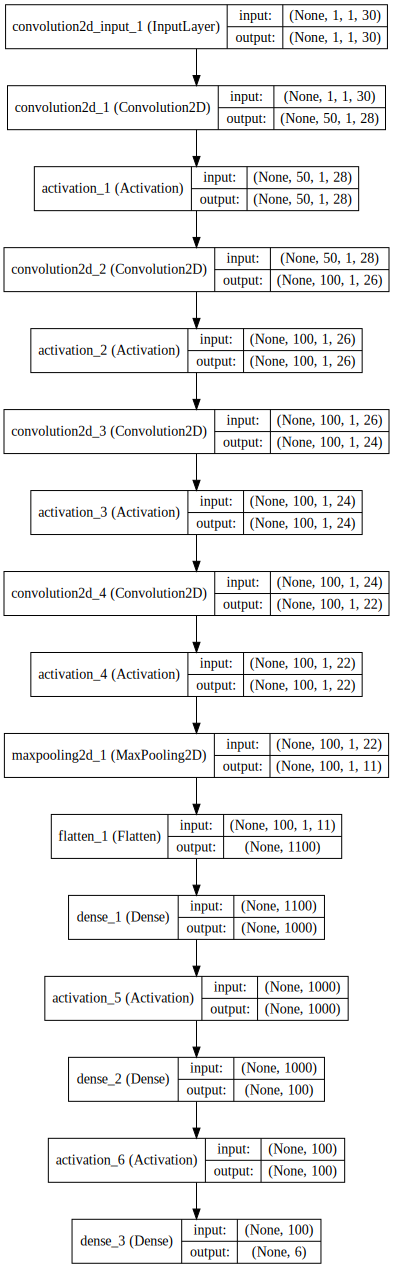

In [10]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
# model.add(Reshape((260, )))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(output_dim = output_dim, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam")

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
nb_epoch = 10
cnn_result = model.fit(x_train, train_ajax['y'], nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.1)

preds = model.predict(x_test)
preds[preds>= 0.5] = 1
preds[preds<0.5] = 0

Train on 700 samples, validate on 78 samples
Epoch 1/10
0s - loss: 0.6719 - val_loss: 0.6494
Epoch 2/10
0s - loss: 0.6222 - val_loss: 0.6467
Epoch 3/10
0s - loss: 0.5976 - val_loss: 0.6545
Epoch 4/10
0s - loss: 0.5814 - val_loss: 0.6818
Epoch 5/10
0s - loss: 0.5715 - val_loss: 0.6762
Epoch 6/10
0s - loss: 0.5476 - val_loss: 0.7362
Epoch 7/10
0s - loss: 0.5233 - val_loss: 0.7376
Epoch 8/10
0s - loss: 0.5010 - val_loss: 0.7376
Epoch 9/10
0s - loss: 0.4788 - val_loss: 0.8278
Epoch 10/10
0s - loss: 0.4464 - val_loss: 0.8466


In [231]:
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = test_ajax['y'][:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'accuracy for %s th dim: %s' % (i, sum_ / all_)

accuracy for 0 th dim: 0.72049689441
accuracy for 1 th dim: 0.621118012422
accuracy for 2 th dim: 0.633540372671
accuracy for 3 th dim: 0.577639751553
accuracy for 4 th dim: 0.586956521739
accuracy for 5 th dim: 0.555900621118


In [ ]:
preds

In [112]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 0], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

IndexError: invalid index to scalar variable.

In [97]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

nb_epoch = 10
cnn_result = model.fit(x_train, np_utils.to_categorical(train_ajax['y'][:, 1], 2), nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.2)

Train on 1320 samples, validate on 330 samples
Epoch 1/10
0s - loss: 0.6859 - acc: 0.6356 - val_loss: 0.6326 - val_acc: 0.6879
Epoch 2/10
0s - loss: 0.6165 - acc: 0.6841 - val_loss: 0.6236 - val_acc: 0.6636
Epoch 3/10
0s - loss: 0.5928 - acc: 0.6909 - val_loss: 0.6103 - val_acc: 0.7000
Epoch 4/10
0s - loss: 0.5768 - acc: 0.7061 - val_loss: 0.6132 - val_acc: 0.6667
Epoch 5/10
0s - loss: 0.5621 - acc: 0.7144 - val_loss: 0.6779 - val_acc: 0.5636
Epoch 6/10
0s - loss: 0.5638 - acc: 0.7061 - val_loss: 0.6082 - val_acc: 0.7061
Epoch 7/10
0s - loss: 0.5626 - acc: 0.7144 - val_loss: 0.5997 - val_acc: 0.7000
Epoch 8/10
0s - loss: 0.5482 - acc: 0.7136 - val_loss: 0.5946 - val_acc: 0.7061
Epoch 9/10
0s - loss: 0.5396 - acc: 0.7076 - val_loss: 0.6573 - val_acc: 0.6909
Epoch 10/10
0s - loss: 0.5369 - acc: 0.7235 - val_loss: 0.6083 - val_acc: 0.6818


In [98]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 1], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

test score: 0.646138517062
test accuracy: 0.6625


In [99]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

nb_epoch = 10
cnn_result = model.fit(x_train, np_utils.to_categorical(train_ajax['y'][:, 2], 2), nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.2)

Train on 1320 samples, validate on 330 samples
Epoch 1/10
0s - loss: 0.6736 - acc: 0.6045 - val_loss: 0.6366 - val_acc: 0.6424
Epoch 2/10
0s - loss: 0.6172 - acc: 0.6818 - val_loss: 0.6334 - val_acc: 0.6273
Epoch 3/10
0s - loss: 0.5992 - acc: 0.6864 - val_loss: 0.6172 - val_acc: 0.6394
Epoch 4/10
0s - loss: 0.5776 - acc: 0.6977 - val_loss: 0.6503 - val_acc: 0.6515
Epoch 5/10
0s - loss: 0.5749 - acc: 0.7015 - val_loss: 0.6268 - val_acc: 0.6333
Epoch 6/10
0s - loss: 0.5602 - acc: 0.7091 - val_loss: 0.6247 - val_acc: 0.6364
Epoch 7/10
0s - loss: 0.5544 - acc: 0.7106 - val_loss: 0.6504 - val_acc: 0.5879
Epoch 8/10
0s - loss: 0.5483 - acc: 0.7106 - val_loss: 0.6741 - val_acc: 0.6152
Epoch 9/10
0s - loss: 0.5321 - acc: 0.7417 - val_loss: 0.6328 - val_acc: 0.6576
Epoch 10/10
0s - loss: 0.5325 - acc: 0.7356 - val_loss: 0.6414 - val_acc: 0.6485


In [100]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 2], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

test score: 0.677830870946
test accuracy: 0.620833333333


## RNN

In [76]:
my_rnn = TimeseriesModel(rows=1, cols=30, output_dim=6, model_type='SimpleRNN')

### data load for RNN

In [77]:
train, test, target = base_data_manager.load_normal_representation_data(output_dim=6, data_type='balance', category_name='ajax')
x_train, y_train, x_tests, y_test = my_lstm.data_transform(train, test)

In [78]:
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

(778, 1, 30)
train samples: 778
test samples: 322


### model

In [79]:
my_rnn.build(rows=1, cols=30, output_dim=6)

In [80]:
result = my_rnn.train(x_train, y_train, batch_size=50, epoch=50, validation_split=0.1)

Train on 700 samples, validate on 78 samples
Epoch 1/50
700/700 [==============================] - 0s - loss: 0.8695 - acc: 0.0400 - val_loss: 0.9088 - val_acc: 0.0513
Epoch 2/50
700/700 [==============================] - 0s - loss: 0.8231 - acc: 0.0571 - val_loss: 0.8716 - val_acc: 0.0641
Epoch 3/50
700/700 [==============================] - 0s - loss: 0.7849 - acc: 0.0743 - val_loss: 0.8440 - val_acc: 0.1026
Epoch 4/50
700/700 [==============================] - 0s - loss: 0.7555 - acc: 0.0957 - val_loss: 0.8188 - val_acc: 0.1154
Epoch 5/50
700/700 [==============================] - 0s - loss: 0.7329 - acc: 0.1357 - val_loss: 0.7971 - val_acc: 0.1026
Epoch 6/50
700/700 [==============================] - 0s - loss: 0.7187 - acc: 0.1729 - val_loss: 0.7798 - val_acc: 0.1410
Epoch 7/50
700/700 [==============================] - 0s - loss: 0.7077 - acc: 0.1971 - val_loss: 0.7661 - val_acc: 0.1538
Epoch 8/50
700/700 [==============================] - 0s - loss: 0.6990 - acc: 0.2229 - val_lo

In [81]:
acc_ls = my_gru.test(x_test, y_test)
for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i, acc_)

accuracy for 0 th dim: 0.723602
accuracy for 1 th dim: 0.645963
accuracy for 2 th dim: 0.618012
accuracy for 3 th dim: 0.580745
accuracy for 4 th dim: 0.565217
accuracy for 5 th dim: 0.478261


## GRU

In [70]:
output_dim = 6
my_gru = TimeseriesModel(rows=1, cols=30, output_dim=output_dim, model_type='GRU')

### data load for GRU

In [71]:
train, test, target = base_data_manager.load_normal_representation_data(output_dim=6, data_type='balance', category_name='ajax')
x_train, y_train, x_tests, y_test = my_lstm.data_transform(train, test)

### model

In [72]:
my_gru.build(rows=1, cols=30, output_dim=6)

In [73]:
result = my_gru.train(x_train, y_train, batch_size=50, epoch=50, validation_split=0.1)

Train on 700 samples, validate on 78 samples
Epoch 1/50
700/700 [==============================] - 0s - loss: 0.7475 - acc: 0.2643 - val_loss: 0.7476 - val_acc: 0.3846
Epoch 2/50
700/700 [==============================] - 0s - loss: 0.7296 - acc: 0.2857 - val_loss: 0.7333 - val_acc: 0.4231
Epoch 3/50
700/700 [==============================] - 0s - loss: 0.7168 - acc: 0.3343 - val_loss: 0.7230 - val_acc: 0.4103
Epoch 4/50
700/700 [==============================] - 0s - loss: 0.7075 - acc: 0.3443 - val_loss: 0.7147 - val_acc: 0.4487
Epoch 5/50
700/700 [==============================] - 0s - loss: 0.6997 - acc: 0.3471 - val_loss: 0.7060 - val_acc: 0.4872
Epoch 6/50
700/700 [==============================] - 0s - loss: 0.6925 - acc: 0.3500 - val_loss: 0.6991 - val_acc: 0.4744
Epoch 7/50
700/700 [==============================] - 0s - loss: 0.6864 - acc: 0.3857 - val_loss: 0.6914 - val_acc: 0.4615
Epoch 8/50
700/700 [==============================] - 0s - loss: 0.6810 - acc: 0.3900 - val_lo

In [75]:
acc_ls = my_gru.test(x_test, y_test)
for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i, acc_)

accuracy for 0 th dim: 0.723602
accuracy for 1 th dim: 0.645963
accuracy for 2 th dim: 0.618012
accuracy for 3 th dim: 0.580745
accuracy for 4 th dim: 0.565217
accuracy for 5 th dim: 0.478261


## LSTM

In [42]:
output_dim = 6
my_lstm = TimeseriesModel(rows=1, cols=30, output_dim=output_dim, model_type='LSTM')

In [43]:
train, test, target = base_data_manager.load_normal_representation_data(output_dim=6, data_type='balance', category_name='ajax')

In [44]:
x_train, y_train, x_test, y_test = my_lstm.data_transform(train, test)

In [45]:
my_lstm.build(rows=1, cols=30, output_dim=6)

In [46]:
result = my_lstm.train(x_train, y_train, batch_size=50, epoch=50, validation_split=0.1)

Train on 700 samples, validate on 78 samples
Epoch 1/50
700/700 [==============================] - 0s - loss: 0.7102 - acc: 0.0557 - val_loss: 0.7021 - val_acc: 0.0385
Epoch 2/50
700/700 [==============================] - 0s - loss: 0.7034 - acc: 0.0557 - val_loss: 0.6964 - val_acc: 0.0641
Epoch 3/50
700/700 [==============================] - 0s - loss: 0.6974 - acc: 0.0586 - val_loss: 0.6905 - val_acc: 0.0641
Epoch 4/50
700/700 [==============================] - 0s - loss: 0.6923 - acc: 0.0629 - val_loss: 0.6860 - val_acc: 0.0513
Epoch 5/50
700/700 [==============================] - 0s - loss: 0.6874 - acc: 0.0600 - val_loss: 0.6825 - val_acc: 0.0769
Epoch 6/50
700/700 [==============================] - 0s - loss: 0.6826 - acc: 0.0729 - val_loss: 0.6780 - val_acc: 0.1026
Epoch 7/50
700/700 [==============================] - 0s - loss: 0.6781 - acc: 0.0786 - val_loss: 0.6741 - val_acc: 0.0897
Epoch 8/50
700/700 [==============================] - 0s - loss: 0.6742 - acc: 0.0843 - val_lo

In [66]:
acc_ls = my_lstm.test(x_test, y_test)
for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i, acc_)

accuracy for 0 th dim: 0.717391
accuracy for 1 th dim: 0.611801
accuracy for 2 th dim: 0.627329
accuracy for 3 th dim: 0.618012
accuracy for 4 th dim: 0.583851
accuracy for 5 th dim: 0.580745


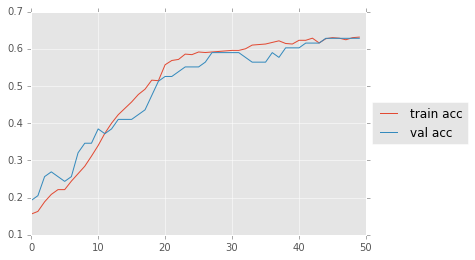

In [32]:
my_lstm.visualize_acc(result=result, epoch=50)

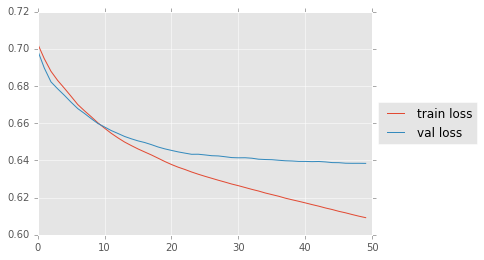

In [33]:
my_lstm.visualize_loss(result=result, epoch=50)

## kNN

In [123]:
from knn import KNearestNeighbor

In [124]:
output_dim = 6
my_knn = KNearestNeighbor()

### data load for kNN

In [130]:
train, test, target = base_data_manager.load_normal_representation_data(data_type='balance', category_name='ajax', output_dim=6)

In [131]:
nn_dist_array, nn_ts_array, nn_label_array = my_knn.fit(train=train['x'], test=test['x'], label=train['y'], k=1, output_dim=6, metrics='dtw')

321

In [132]:
nn_label_array

array([[ 0.,  0.,  0.,  0.,  0.,  0.]])